In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout

In [2]:
IMAGE_SIZE = 200

img_files = glob.glob('data/images/*.png')
img_files.sort()

x = []
for f in img_files:
    img = cv2.imread(f)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    x.append(np.array(img))

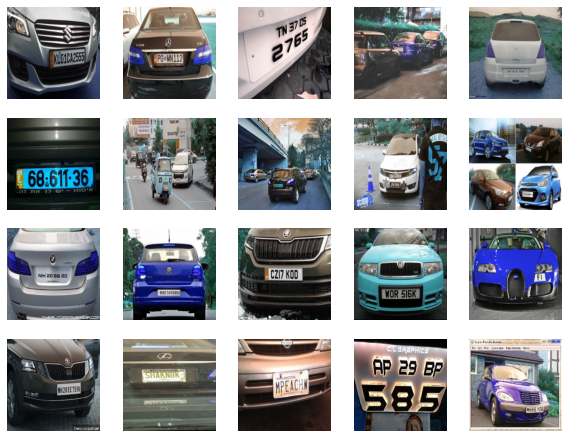

In [3]:
plt.figure(figsize=(10, 20))

for i in range(0, 20) :
    plt.subplot(10, 5, i+1)
    plt.axis('off')
    plt.imshow(x[i])

In [4]:
from lxml import etree

def resize_annotation(f):
    tree = etree.parse(f)
    
    for dim in tree.xpath("size"):
        width = float(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
        
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text) / (width)
        ymin = int(dim.xpath("ymin")[0].text) / (height)
        xmax = int(dim.xpath("xmax")[0].text) / (width)
        ymax = int(dim.xpath("ymax")[0].text) / (height)
        
    return [xmin, ymin, xmax, ymax]

In [5]:
annot_files = glob.glob('data/annotations/*.xml')
annot_files.sort()

annot = []
for a_f in annot_files:
    annot.append(resize_annotation(a_f))

df = pd.DataFrame(np.array(annot), columns=['xmin', 'ymin', 'xmax', 'ymax'])
df['images'] = img_files

In [6]:
df.head()

,xmin,ymin,xmax,ymax,images
0,0.4520,0.466418,0.8380,0.645522,data/images/Cars0.png
1,0.3350,0.516129,0.6550,0.645161,data/images/Cars1.png
2,0.3500,0.022222,0.7575,0.657778,data/images/Cars10.png
3,0.4375,0.426966,0.5350,0.490637,data/images/Cars100.png
4,0.4175,0.673333,0.6000,0.733333,data/images/Cars101.png


In [7]:
import os

image_gen_train = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_data_gen = image_gen_train.flow_from_dataframe(df, 
                                              x_col='images', 
                                              y_col=['xmin', 'ymin', 'xmax', 'ymax'],
                                              batch_size=50,
                                              shuffle=True,
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              class_mode="other",
                                              subset="training")

val_data_get = image_gen_train.flow_from_dataframe(df, 
                                              x_col='images', 
                                              y_col=['xmin', 'ymin', 'xmax', 'ymax'],
                                              batch_size=50,
                                              shuffle=True,
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              class_mode="other",
                                              subset="validation")

Found 390 validated image filenames.
Found 43 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/logging/__init__.py", line 1081, in emit
    msg = self.format(record)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/logging/__init__.py", line 925, in format
    return fmt.format(record)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/logging/__init__.py", line 664, in format
    record.message = record.getMessage()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/runpy.py", line 193, in _run_

In [8]:
def create_model():
    model = tf.keras.Sequential()
    model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="sigmoid"))

    model.layers[-6].trainable = False
    
    adam = Adam(lr=0.0005)
    model.compile(optimizer=adam, loss="mse")
    
    return model

In [9]:
STEP_SIZE_TRAIN = int(np.ceil(train_data_gen.n / train_data_gen.batch_size))
STEP_SIZE_VAL = int(np.ceil(val_data_get.n / val_data_get.batch_size))

train_data_gen.reset()
val_data_get.reset()

In [10]:
def train_model():
    model = create_model()

    history = model.fit_generator(train_data_gen,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=val_data_get,
        validation_steps=STEP_SIZE_VAL,
        epochs=15)
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    model.save('plate_detection_model.h5')
    
    return model

In [11]:
plate_detection_model = tf.keras.models.load_model('plate_detection_model.h5')

plate_detection_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               2359424   
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 260       
Total params: 17,086,788
Trainable params: 2,372,100
Non-trainable params: 14,714,688
_________________________________

In [23]:
def predict_bounding_box(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img / 255.0, dsize=(IMAGE_SIZE,IMAGE_SIZE))

    y_pred = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3))[0]
    y_pred = list(map(lambda x: int(x * IMAGE_SIZE), y_pred))
    
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (y_pred[2], y_pred[3]), (y_pred[0], y_pred[1]), (0, 0, 255), 5)
    plt.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


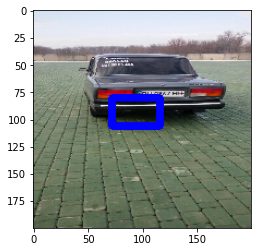

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


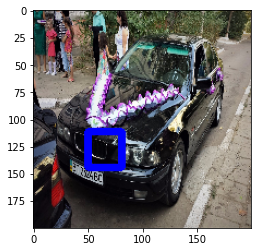

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


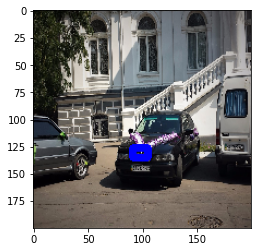

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


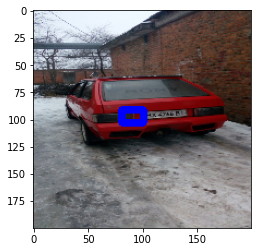

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


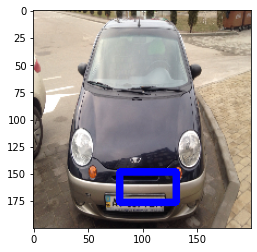

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


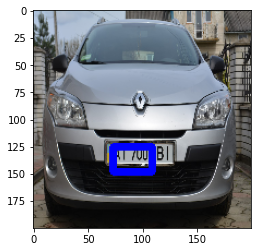

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


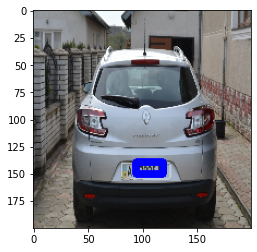

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


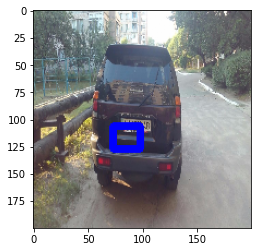

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


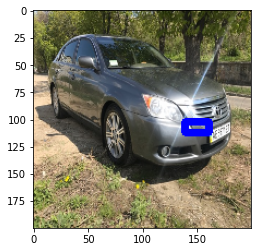

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


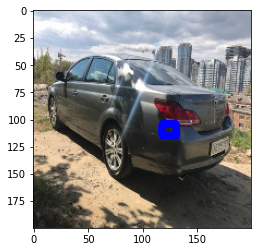

In [24]:
img_files = glob.glob('/Users/varvarahurevich/Downloads/autoriaNumberplateDataset-2018-11-20/train/*')
img_files.sort()

x = []
for f in img_files[30:40]:
    predict_bounding_box(f, plate_detection_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


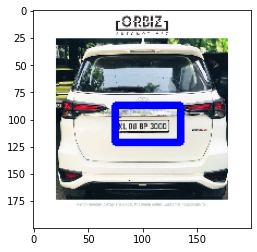

In [25]:
predict_bounding_box('/Users/varvarahurevich/Documents/test4.jpeg', plate_detection_model)